# Setup

In [1]:
%%time
%%capture
%pip install pandas scikit-learn matplotlib seaborn
%pip install torch==2.8.0+cpu torchvision==0.23.0+cpu torchaudio==2.8.0+cpu \
    --index-url https://download.pytorch.org/whl/cpu

CPU times: user 19.7 ms, sys: 16.6 ms, total: 36.3 ms
Wall time: 2.54 s


# Data preparation

In [2]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

bunch = load_breast_cancer()

# Convert features to DataFrame
X = pd.DataFrame(bunch.data, columns=bunch.feature_names)

# Convert target to Series
y = pd.Series(bunch.target, name="target")

print(X.head())
print(y.head())

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0           

In [3]:
print(y.value_counts())

target
1    357
0    212
Name: count, dtype: int64


In [4]:
# Split the data
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3, # 30% goes to val+test
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, # half of the 30%: 15% val, 15% test
    random_state=42,
    stratify=y_temp
)


# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to tensor
import torch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(y_test.values,  dtype=torch.float32).unsqueeze(1)

print(f'X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}')

X_train: torch.Size([398, 30]), X_val: torch.Size([85, 30]), X_test: torch.Size([86, 30])
y_train: torch.Size([398, 1]), y_val: torch.Size([85, 1]), y_test: torch.Size([86, 1])


In [5]:
#Create datasets and dataloaders
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_dataset_size = len(train_dataset)
val_dataset_size = len(val_dataset)
test_dataset_size = len(test_dataset)

# Torch model

In [6]:
import torch.nn as nn

# Define the model
class classifier(nn.Module):
    def __init__(self, 
                 input_size=X_train.shape[1],
                hidden_size=32,
                output_size=1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize Loss
criterion = nn.BCEWithLogitsLoss()

# Model Training  

In [7]:
# accuracy
def compute_accuracy(model, data_loader, data_set_size):
    model.eval()
    with torch.no_grad():
        accuracy_accumulator = 0
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            outputs = torch.sigmoid(outputs)
            preds = (outputs >= 0.5).float()
            running_accuracy = (preds == y_batch).float().mean()
            running_accuracy = float(running_accuracy)
            accuracy_accumulator += running_accuracy * X_batch.size(0)
        accuracy = accuracy_accumulator / data_set_size
        return accuracy

In [8]:
#training loop
def training(model, optimizer, epochs,
            train_loader, val_loader,
            train_dataset_size=train_dataset_size, val_dataset_size=val_dataset_size, 
            verbose = True):

    train_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss_accumulator = 0
        for X_batch,y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            running_loss = criterion(outputs, y_batch)
            ## To ensure the train loss accounts for batches of different sizes, 
            ## we multiply each running loss by the number of elements in the batch. 
            ## The final train loss is then divided by the total number of samples in the training set.
            train_loss_accumulator += running_loss.item() * X_batch.size(0)
            running_loss.backward()
            optimizer.step()
        train_loss = train_loss_accumulator / train_dataset_size
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            val_loss_accumulator = 0
            for X_batch,y_batch in val_loader:
                outputs = model(X_batch)
                running_loss = criterion(outputs, y_batch)
                val_loss_accumulator += running_loss.item() * X_batch.size(0)
            val_loss = val_loss_accumulator / val_dataset_size
    
        if (epoch+1)%100 == 0 and verbose:
            print('Epoch :',epoch+1,', train loss: ', train_loss, ', val loss: ', val_loss)
            
    train_accuracy = compute_accuracy(model, train_loader, train_dataset_size)
    val_accuracy  = compute_accuracy(model, val_loader, val_dataset_size)
    if verbose:
        print(f"Accuracy on training data: {train_accuracy*100}%")
        print(f"Accuracy on val data: {val_accuracy*100}%")
    return train_accuracy, val_accuracy

# Parameter search

In [9]:
import torch.optim as optim

learning_rates = [1e-4, 5e-4, 1e-3, 1e-2]
weight_decays = [0, 1e-4, 1e-3, 1e-2]
batch_sizes = [16, 32, 64]
epochs = 3

parameter_search = []

for lr in learning_rates:
    for wd in weight_decays:
        for bs in batch_sizes:
            model_search = classifier()
            optimizer_search = optim.Adam(model_search.parameters(), lr=lr, weight_decay=wd)
            train_loader_search = DataLoader(train_dataset, bs, shuffle=True)
            val_loader_search = DataLoader(val_dataset, bs, shuffle=False)
            
            train_acc, val_acc = training(model_search, optimizer_search, epochs,
                                          train_loader_search, val_loader_search,
                                          verbose=False)

            search_dic = {
                        'learning_rate': lr,
                        'weight_decay': wd,
                        'batch_size': bs,
                        'train_acc': train_acc,
                        'val_acc': val_acc
                        }
            print(search_dic)
            parameter_search.append(search_dic)

# pick the best
best_params = max(parameter_search, key=lambda x: x['val_acc'])

print("Best hyperparameters:")
print(best_params)

{'learning_rate': 0.0001, 'weight_decay': 0, 'batch_size': 16, 'train_acc': 0.9296482412060302, 'val_acc': 0.9294117654071135}
{'learning_rate': 0.0001, 'weight_decay': 0, 'batch_size': 32, 'train_acc': 0.6834170860261773, 'val_acc': 0.6470588291392607}
{'learning_rate': 0.0001, 'weight_decay': 0, 'batch_size': 64, 'train_acc': 0.8417085418150053, 'val_acc': 0.8588235315154581}
{'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 16, 'train_acc': 0.472361809344747, 'val_acc': 0.505882353291792}
{'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 32, 'train_acc': 0.6005025122632932, 'val_acc': 0.6000000042073866}
{'learning_rate': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64, 'train_acc': 0.655778894172841, 'val_acc': 0.7411764733931597}
{'learning_rate': 0.0001, 'weight_decay': 0.001, 'batch_size': 16, 'train_acc': 0.8065326639156246, 'val_acc': 0.7882352948188782}
{'learning_rate': 0.0001, 'weight_decay': 0.001, 'batch_size': 32, 'train_acc': 0.6809045232121

# Train the model

In [10]:
model_1 = classifier()
lr = 0.01
weight_decay = 0.0
batch_size = 16
optimizer_1 = optim.Adam(model_1.parameters(), lr=lr, weight_decay=weight_decay)
epochs = 20

train_loader_1 = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader_1 = DataLoader(val_dataset, batch_size, shuffle=False)

train_acc, val_acc = training(model_1, optimizer_1, epochs,
                              train_loader_1, val_loader_1)

Accuracy on training data: 99.49748743718592%
Accuracy on val data: 97.6470588235294%


# Visualization and Interpretation  

In [11]:
def run_model(model, data_loader):
    model.eval()
    y = []
    y_hat = []
    y_scores = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_batch = y_batch.cpu().tolist()
            y.extend(y_batch)
            
            outputs = model(X_batch)
            y_scores.extend(outputs.flatten().tolist()) 
            
            predictions = (outputs >= 0.5).float()
            predictions = predictions.flatten().tolist()
            y_hat.extend(predictions)
            
    return y, y_scores, y_hat

# Usage
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
y, y_scores, y_hat = run_model(model_1, test_loader)

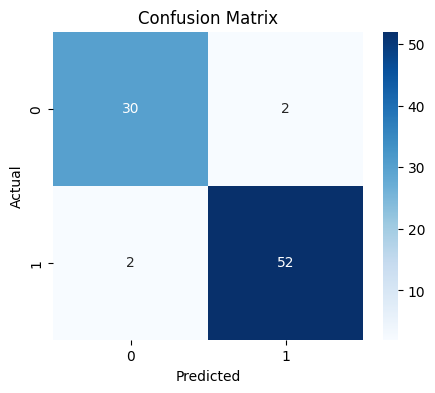

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9375    0.9375    0.9375        32
         1.0     0.9630    0.9630    0.9630        54

    accuracy                         0.9535        86
   macro avg     0.9502    0.9502    0.9502        86
weighted avg     0.9535    0.9535    0.9535        86



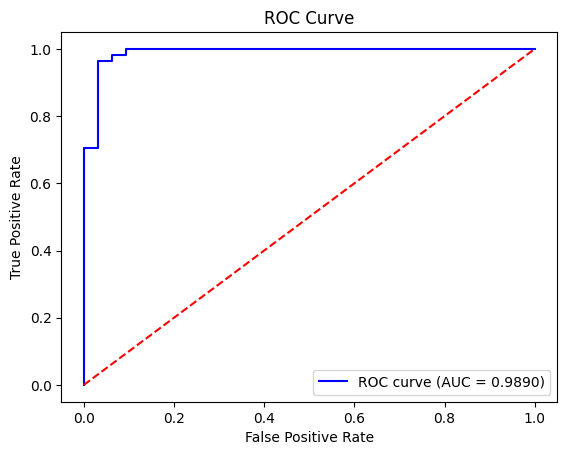

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

#Confusion Matrix Visualization
cm = confusion_matrix(y, y_hat)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y, y_hat, digits=4)
print("Classification Report:\n", report)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Model Saving and Loading  

In [14]:
# Save the model
torch.save(model_1.state_dict(), 'saved_model.pth')
# Load the model
model_l = classifier()
model_l.load_state_dict(torch.load('saved_model.pth'))
# Evaluate the loaded model
l_train_loader = DataLoader(train_dataset, batch_size, shuffle=False)
l_test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
train_accuracy = compute_accuracy(model_l, l_train_loader, len(train_dataset))
test_accuracy  = compute_accuracy(model_l, l_test_loader, len(test_dataset))
print(f"Accuracy on training data: {train_accuracy*100}%")
print(f"Accuracy on test data: {test_accuracy*100}%")

Accuracy on training data: 99.49748743718592%
Accuracy on test data: 95.34883720930233%
